In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

# print('# File sizes')
# for f in os.listdir('../input'):
#     if 'zip' not in f:
#         print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

## Dataset Split

In [2]:
df = pd.read_csv('data/train.csv')
df_test = df.sample(frac=0.3)
df_train = df[~df.index.isin(df_test.index)]
df = df.reset_index()
df_test = df_test.reset_index()
df_test = df_test.drop(['index','id'],axis=1)
df_test.insert(0,'test_id',df_test.index)
df_test.head(5)

,test_id,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
0,0,153730,153731,how do i play orbiter space flight simulator,why is it that after more than 50 years of man...,0,1.0,31.0,0.032258
1,1,113726,33164,what is the difference between the republican ...,what is the difference between a democrat and ...,1,5.0,24.0,0.208333
2,2,319193,193762,what rights do you have if you have been accus...,what rights do you have if you have been accus...,0,19.0,40.0,0.475000
3,3,8023,16017,what were the major effects of the cambodia ea...,what were the major effects of the cambodia ea...,1,16.0,37.0,0.432432
4,4,83942,83943,how do you come to terms with the fact that yo...,is david duke a bad person,0,3.0,20.0,0.150000


In [3]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,10.0,23.0,0.434783
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4.0,20.0,0.200000
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.0,19.0,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,2.0,20.0,0.100000
5,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,8.0,31.0,0.258065


In [4]:
if len(df) == len(df_test)+len(df_train):
    print('True.')
len(df_test)/len(df)

True.


0.2999997526509633

## Text analysis

First off, some quick histograms to understand what we're looking at. **Most analysis here will be only on the training set, to avoid the auto-generated questions**

mean-train 60.02 std-train 32.22 mean-test 59.86 std-test 31.88 max-train 1173.00 max-test 1163.00


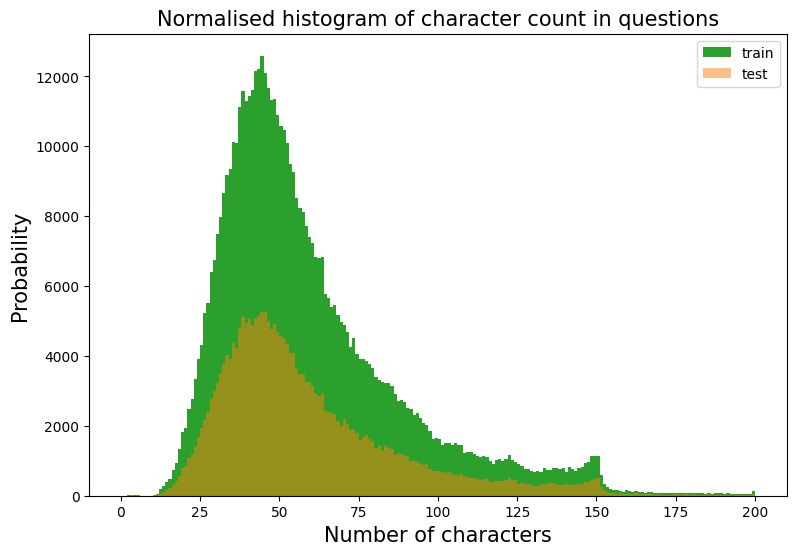

In [5]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(9, 6))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2],  label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1],  alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 12.71 std-train 6.75 mean-test 12.69 std-test 6.68 max-train 271.00 max-test 271.00


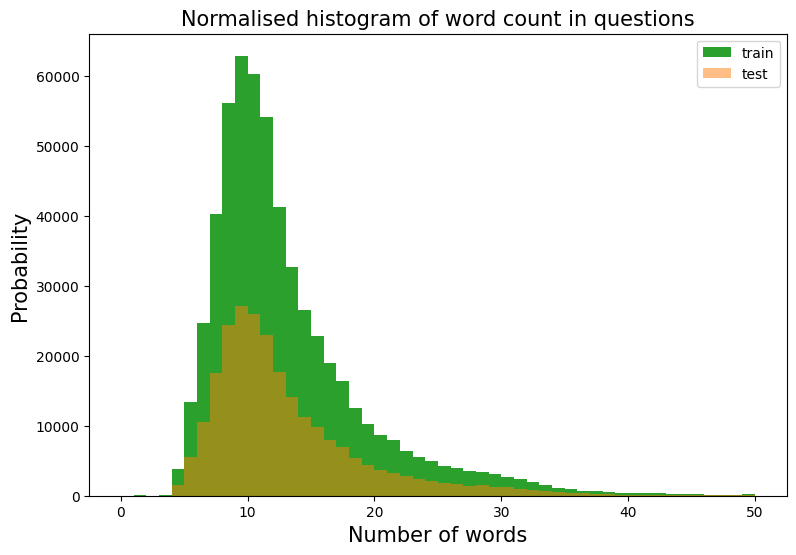

In [6]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(9, 6))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2],  label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1],  alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

Text(0.5, 0, 'word_match_share')

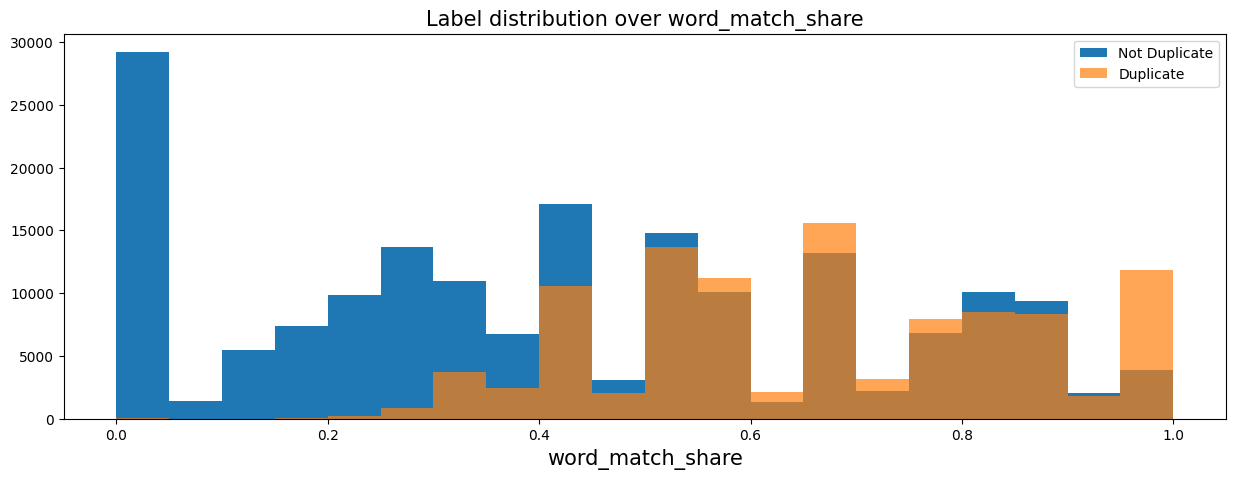

In [7]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

In [8]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [9]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 3.6421248156174313e-06), ('what', 4.2180388650101025e-06), ('is', 4.743900529893689e-06), ('i', 6.003878505514562e-06), ('how', 6.0737474414338905e-06), ('a', 6.297784439434207e-06), ('to', 6.475677355851422e-06), ('in', 6.755524330020874e-06), ('do', 7.771094636390483e-06), ('of', 8.216791835795632e-06)]

Least common words and weights: 


[('quikly', 9.998000399920016e-05),
 ('tiago', 9.998000399920016e-05),
 ('dcx3400', 9.998000399920016e-05),
 ('slits', 9.998000399920016e-05),
 ('3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('oitnb', 9.998000399920016e-05),
 ('forgetful', 9.998000399920016e-05),
 ('essex', 9.998000399920016e-05),
 ('prospering', 9.998000399920016e-05)]

In [10]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/var/folders/ql/fnvk6v291nxg7rmlwmh_m7m80000gn/T/ipykernel_7488/830548937.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


Text(0.5, 0, 'word_match_share')

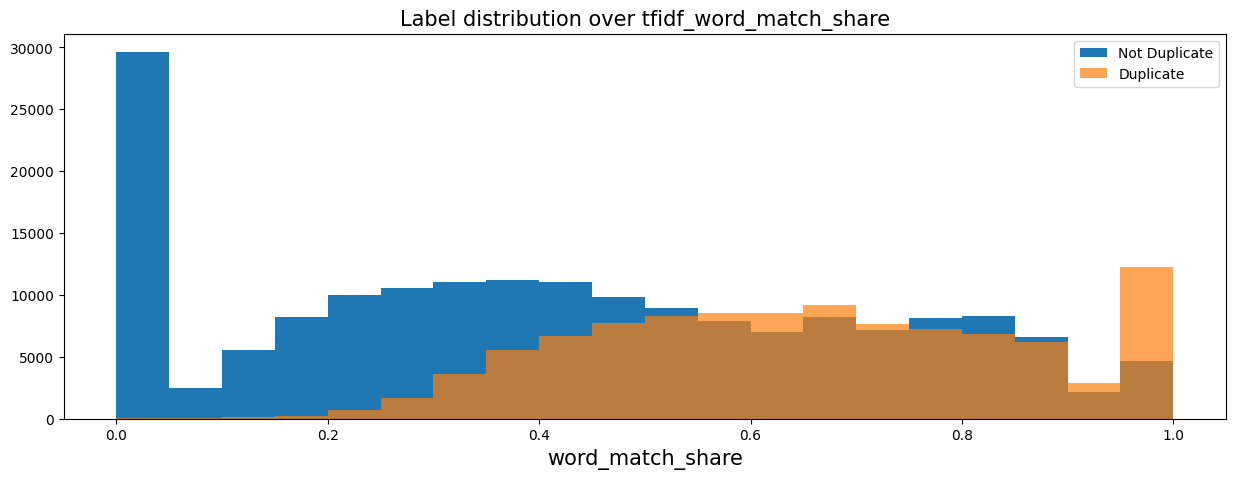

In [11]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

## Data Preparation

In [12]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1)

y_train = df_train['is_duplicate'].values

/var/folders/ql/fnvk6v291nxg7rmlwmh_m7m80000gn/T/ipykernel_7488/830548937.py:17: RuntimeWarning: invalid value encountered in scalar divide
  R = np.sum(shared_weights) / np.sum(total_weights)


In [13]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [14]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68776	valid-logloss:0.68777


/Users/panqiyang/mambaforge/envs/dl-mps/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	train-logloss:0.64384	valid-logloss:0.64392
[20]	train-logloss:0.61272	valid-logloss:0.61288
[30]	train-logloss:0.59000	valid-logloss:0.59023
[40]	train-logloss:0.57305	valid-logloss:0.57336
[50]	train-logloss:0.56007	valid-logloss:0.56043
[60]	train-logloss:0.55011	valid-logloss:0.55052
[70]	train-logloss:0.54232	valid-logloss:0.54276
[80]	train-logloss:0.53630	valid-logloss:0.53678
[90]	train-logloss:0.53153	valid-logloss:0.53204
[100]	train-logloss:0.52766	valid-logloss:0.52819
[110]	train-logloss:0.52458	valid-logloss:0.52511
[120]	train-logloss:0.52228	valid-logloss:0.52282
[130]	train-logloss:0.52047	valid-logloss:0.52102
[140]	train-logloss:0.51904	valid-logloss:0.51960
[150]	train-logloss:0.51788	valid-logloss:0.51845
[160]	train-logloss:0.51694	valid-logloss:0.51752
[170]	train-logloss:0.51613	valid-logloss:0.51672
[180]	train-logloss:0.51549	valid-logloss:0.51608
[190]	train-logloss:0.51496	valid-logloss:0.51555
[200]	train-logloss:0.51454	valid-logloss:0.51514
[210]	tra

In [31]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

threshold = 0.5

def pred_dup(row):
    if row['pred']<=threshold:
        return 0
    else:
        return 1

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['pred'] = p_test
sub['pred_duplicate'] = sub.apply(pred_dup, axis=1)
sub['is_duplicate'] = df_test['is_duplicate']
# sub.to_csv('simple_xgb.csv', index=False)
sub.head(5)

,test_id,pred,pred_duplicate,is_duplicate
0,0,0.011422,0,0
1,1,0.395479,0,1
2,2,0.486046,0,0
3,3,0.551407,1,1
4,4,0.474368,0,0


In [33]:
def hit(row):
    if row['pred_duplicate']==row['is_duplicate']:
        return 1
    else:
        return 0
    
sub['correct'] = sub.apply(hit,axis=1)
acc = sub['correct'].sum()/len(sub)
acc

0.6937898850650529

In [45]:
prec = len(sub.loc[(sub['is_duplicate']==1) & (sub['pred_duplicate']==1)])/len(sub.loc[sub['pred_duplicate']==1])
prec

0.5881632834757835

In [46]:
# sub[sub['is_duplicate']==1 & sub['pred_duplicate']==1]
recall = len(sub.loc[(sub['is_duplicate']==1) & (sub['pred_duplicate']==1)])/len(sub.loc[sub['is_duplicate']==1])
recall

0.5864272874547836